In [2]:
from pymongo import MongoClient
import pprint

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

import json
import time
import copy 
from bson import ObjectId

# Web Scraping


##  Success criteria:

I will be successful today if I can...

1. Identify some use cases for mongo-db as opposed to traditional RDBMS
2. Create, Read, Update and Delete documents using the mongo shell
2. Use pymongo and requests to pull a website's html into a collection 
3. Use beautiful soup to parse html

## Outline

1. *Review* MongoDB and PyMongo
2. *Explain* and *Use* the basic concepts of HTML with regard to fetching data:
    * Connecting to web pages from Python
    * Parsing HTML in Python
3. *Write* code to pull elements from websites using the BeautifulSoup library 
4. *Describe* a typical pipeline for scraping data from the web and apply this process to scrap monster.com for data science jobs in Austin.
5. *Use* public API's to fetch pre-formatted data using BeautifulSoup.

## Resources

* [w3 schools](http://www.w3schools.com/) : HTML tags and thier attributes.
* [BeautifulSoup Documentation](http://www.crummy.com/software/BeautifulSoup/bs4/doc/)

-----

# Review MongoDB and PyMongo

MongoDB and PyMongo is a NoSQL database program.  Let's first compare SQL to NoSQL. 

## SQL versus NoSQL 

### Example: Structure of a Relational Database versus a Document Oriented Database: 

<center><img src="img/sql_vs_mongo_table.png" style="width: 700px"></center>

![](img/rd_mongo.jpg)


## MongoDB

### What's it about? 

* MongoDB is a document-oriented database, an alternative to RDBMS, used for storing semi-structured data.
* JSON-like objects form the data model, rather than RDBMS tables.
* Schema is optional.
* Sub-optimal for complicated queries.

### Structure of the database.

* MongoDB is made up of databases which contain collections (tables).
* A collection is made up of documents (analogous to rows or records).
* Each document is a JSON object made up of key-value pairs (analogous to columns).

So a RDBMS defines columns at the table level, document oriented database defines its fields at a document level.

## PyMongo 

In this lecture, we will create a database and collection.  Then we will insert documents into a collection. Let's see how to do this:

In [3]:
# Connect to the hosted MongoDB instance 
client = MongoClient('localhost', 27017)

In [4]:
db = client['reddit'] # create or access already existing database 

In [5]:
db.list_collection_names() #any collections available? 

['comments']

In [6]:
comments = db['comments'] # access already existing collection (this would also create a new collection)

In [7]:
comments.find()

In [8]:
for comment in comments.find():  # find documents in collection from this morning
    print(comment)

{'_id': ObjectId('6056341c69dd3c927a0ad12c'), 'comment_id': 'laugher', 'body': 'lol'}


In [9]:
comments.insert_one(
            {'comment_id':'laugher',
            'body': 'lol'}
)

In [10]:
for comment in comments.find():  # find documents in collection from this morning
    print(comment)

{'_id': ObjectId('6056341c69dd3c927a0ad12c'), 'comment_id': 'laugher', 'body': 'lol'}
{'_id': ObjectId('6062d84945fcb1c719771878'), 'comment_id': 'laugher', 'body': 'lol'}


In [13]:
#Delete an extra item if you ran the above insert_one twice
db.comments.delete_one({'_id': ObjectId('6062d84945fcb1c719771878')})

In [14]:
for comment in comments.find():  # find documents in collection from this morning
    print(comment)

{'_id': ObjectId('6056341c69dd3c927a0ad12c'), 'comment_id': 'laugher', 'body': 'lol'}


-----

# *Explain* and *Use* the basic concepts of HTML with regard to fetching data

* Documents on the web are generally written in <span style="text-decoration: underline">**H**yper**T**ext **M**arkup **L**anguage</span>, HTML, which can be natively viewed by browsers, the tool that we use to browse the web.

### HTML

**H**yper**T**ext **M**arkup **L**anguage

A *markup language* (think markdown) that forms the building blocks of all websites. It specified not just the text of the document but also the organization (into sections and paragraphs and lists and such). It can also control the layout of the document (the font and color and size and such) though that is properly handled with Cascading Style Sheets (CSS)

It consists of opening and closing tags enclosed in angle brackets (like `<html>` and `</html>`) often with more HTML in between.

A minimal HTML document, unfortuantely, contains a lot of cruft.  Here's one I got from [https://www.sitepoint.com/a-minimal-html-document/](https://www.sitepoint.com/a-minimal-html-document/).


```html
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
    "http://www.w3.org/TR/html4/strict.dtd">
<html lang="en">
  <head>
  
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <title>title</title>
    <link rel="stylesheet" type="text/css" href="style.css">
    <script type="text/javascript" src="script.js"></script>
  </head>
  <body>
		
  </body>
</html>
```

The key=value pairs inside of a tag are called attributes. The `<link>` and `<script>` tags aren't necessary, but appear in more or less every HTML document.

* The `<link>` tag points to a **stylesheet**, which controls how different parts of the document are rendered in the browser.  This makes things pretty.
* The `<script>` tag points to a **javascript** program.  This allows programmers to add *dynamic behaviour* to a html document.
* The `<body>` tag contains the guts of your document.

### Important Tags

```html
<a href="http://www.w3schools.com">A hyperlink to W3Schools.com!</a>

<h1>This is a header!</h1>

<p>This is a paragraph!</p>

<h2>This is a Subheading!</h2>

<table>
  This is a table!
  <tr>
    <th>The header in the first row.</th>
    <th>Another header in the first row.</th>
  </tr>
  <tr>
    <td>An entry in the second row.</td>
    <td>Another entry in the second row.</td>
  </tr>
</table>

<ul>
  This is an unordered list!
  <li>This is the first thing in the list!</li>
  <li>This is the second thing in the list!</li>
</ul>
<div>Specifies a division of the document, generally with additional attributes specifying layout and behavior.</div>
A <span>span is similar</span> but occurs in the middle of a line.

```

## HTTP Requests

To get data from the web, you need to make a HTTP request.  The two most important request types are:

* GET (queries data, no data is *sent*)
    - used for fetching documents
    


* POST (updates data, *data must be sent*)
    - used for updating data

    
<br>

Usually HTTP requests are sent by browsers (like Chrome or Safari) but `curl` is a command line program for sending HTTP requests.  It's easy to send a `GET` request to a url.

## Requests Library

* The [requests](http://docs.python-requests.org/en/latest/index.html) library is designed to simplify the process of making http requests within Python.
* The interface is mindbogglingly simple:
    1. Instantiate a requests object to the request, this will mostly be a `get`, with the URL and optional parameters you'd like passed through the request.
    2. That instance makes the results of the request available via attributes/methods, i.e. we now have a python object representation of the website to play with.
    
Let's do a simple demo where I get the hypertext from deertier.com:

In [15]:
import requests
deer_tier_url = 'http://deertier.com/Leaderboard/AnyPercentRealTime'
r = requests.get(deer_tier_url)

In [16]:
r

<Response [200]>

A status code of `200` means that everything went well.

In [17]:
r.status_code

200

We can also get the HTML via text attribute.  Below I will use the pprint module to make printed text readable

In [18]:
import pprint
pprint.pprint(r.text[:1000])

('<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" '
 '"http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\r\n'
 '\r\n'
 '<html xmlns="http://www.w3.org/1999/xhtml">\r\n'
 '<head runat="server">\r\n'
 '    \r\n'
 '    <link rel="apple-touch-icon" sizes="180x180" '
 'href="/apple-touch-icon.png" />\r\n'
 '    <link rel="icon" type="image/png" href="/favicon-32x32.png" '
 'sizes="32x32" />\r\n'
 '    <link rel="icon" type="image/png" href="/favicon-16x16.png" '
 'sizes="16x16" />\r\n'
 '    <link rel="manifest" href="/manifest.json" />\r\n'
 '    <link rel="mask-icon" href="/safari-pinned-tab.svg" color="#fec200" '
 '/>\r\n'
 '\r\n'
 '    <meta name="apple-mobile-web-app-title" content="Deer Tier" />\r\n'
 '    <meta name="application-name" content="Deer Tier" />\r\n'
 '    <meta name="theme-color" content="#331f52" />\r\n'
 '    <meta name="viewport" content="width=device-width" />\r\n'
 '\r\n'
 '    <link rel="Stylesheet" type="text/css" href="/CSS/Reset.css" />\r\

-----

# *Write* code to pull elements from websites using the BeautifulSoup library 

In order to demo Beautiful Soup, we will first parse a simple webpage in this repo saved to the file name **basic.html**.  First let's read in this file as a string and pass it along to beautiful soup. 

In [20]:
ls

MongoDB-intro.pdf                 img/
Web_scraping_words_of_wisdom.pdf  monster_ds_job_data.csv
basic.html                        web-scraping.ipynb


In [21]:
# read in html
with open('basic.html', 'r') as myfile:
    html_str = myfile.read()

In [23]:
html_str

'<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"\n    "http://www.w3.org/TR/html4/strict.dtd">\n<html lang="en">\n  <head>\n    <meta http-equiv="content-type" content="text/html; charset=utf-8">\n    <title>title</title>\n    <link rel="stylesheet" type="text/css" href="style.css">\n    <script type="text/javascript" src="script.js"></script>\n  </head>\n  <body>\n\u200b\n    <div>Defines a division or section of the docuemnt.</div>\n    <a href="http://www.w3schools.com">A Gyperlink to W3Schools.com!</a>\n\u200b\n    <h1>This is a header!</h1>\n\u200b\n    <p>This is a paragraph!</p>\n\u200b\n    <h2>This is a Subheading!</h2>\n\u200b\n    <table>\n      <tr>\n        <td>An entry in the first row.</td>\n        <td>Another entry in the first row.</td>\n      </tr>\n      <tr>\n        <td>An entry in the second row.</td>\n        <td>Another entry in the second row.</td>\n      </tr>\n    </table>\n\u200b\n    <ul>\n      This is a list!\n      <li>This is the first thing in the l

In [24]:
# pass to beautiful soup
soup = BeautifulSoup(html_str, 'html.parser')

In [34]:
# soup

In [26]:
print(soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
    "http://www.w3.org/TR/html4/strict.dtd">
<html lang="en">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <title>
   title
  </title>
  <link href="style.css" rel="stylesheet" type="text/css"/>
  <script src="script.js" type="text/javascript">
  </script>
 </head>
 <body>
  ​
  <div>
   Defines a division or section of the docuemnt.
  </div>
  <a href="http://www.w3schools.com">
   A Gyperlink to W3Schools.com!
  </a>
  ​
  <h1>
   This is a header!
  </h1>
  ​
  <p>
   This is a paragraph!
  </p>
  ​
  <h2>
   This is a Subheading!
  </h2>
  ​
  <table>
   <tr>
    <td>
     An entry in the first row.
    </td>
    <td>
     Another entry in the first row.
    </td>
   </tr>
   <tr>
    <td>
     An entry in the second row.
    </td>
    <td>
     Another entry in the second row.
    </td>
   </tr>
  </table>
  ​
  <ul>
   This is a list!
   <li>
    This is the first thing in the list!
   </li>
   

In [53]:
print(soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
    "http://www.w3.org/TR/html4/strict.dtd">
<html lang="en">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <title>
   title
  </title>
  <link href="style.css" rel="stylesheet" type="text/css"/>
  <script src="script.js" type="text/javascript">
  </script>
 </head>
 <body>
  ​
  <div>
   Defines a division or section of the docuemnt.
  </div>
  <a href="http://www.w3schools.com">
   A Gyperlink to W3Schools.com!
  </a>
  ​
  <h1>
   This is a header!
  </h1>
  ​
  <p>
   This is a paragraph!
  </p>
  ​
  <h2>
   This is a Subheading!
  </h2>
  ​
  <table>
   <tr>
    <td>
     An entry in the first row.
    </td>
    <td>
     Another entry in the first row.
    </td>
   </tr>
   <tr>
    <td>
     An entry in the second row.
    </td>
    <td>
     Another entry in the second row.
    </td>
   </tr>
  </table>
  ​
  <ul>
   This is a list!
   <li>
    This is the first thing in the list!
   </li>
   

####  Beautiful Soup: Tools and Finding tags

First you can easily find HTML tags in the original document with Beautiful Soup.  One way is to use the tag's name.  For example below I find the title of our document

In [30]:
soup.title

<title>title</title>

A tag may have attribute(s). You can access these attributes like a dictionary:

In [37]:
soup.div

<div>Defines a division or section of the docuemnt.</div>

In [39]:
# soup.div['class']

Next, let's try to grab the second table...

In [41]:
soup.table

<table>
<tr>
<td>An entry in the first row.</td>
<td>Another entry in the first row.</td>
</tr>
<tr>
<td>An entry in the second row.</td>
<td>Another entry in the second row.</td>
</tr>
</table>

If you want to grab all the `<table>` tags you can use the find_all() method: 

In [42]:
tables = soup.find_all('table')

In [43]:
tables

[<table>
 <tr>
 <td>An entry in the first row.</td>
 <td>Another entry in the first row.</td>
 </tr>
 <tr>
 <td>An entry in the second row.</td>
 <td>Another entry in the second row.</td>
 </tr>
 </table>]

Note, you can specify the tag and html attributes using find_all(); if no attribute name given it is the class attribute.

In [44]:
soup.find_all('div','myDiv')

[]

In [56]:
indices = tables[0].find_all('tr')
rows = tables[0].find_all('tr')
indices,rows

([<tr>
  <td>An entry in the first row.</td>
  <td>Another entry in the first row.</td>
  </tr>,
  <tr>
  <td>An entry in the second row.</td>
  <td>Another entry in the second row.</td>
  </tr>],
 [<tr>
  <td>An entry in the first row.</td>
  <td>Another entry in the first row.</td>
  </tr>,
  <tr>
  <td>An entry in the second row.</td>
  <td>Another entry in the second row.</td>
  </tr>])

In [57]:
all_data = []
columns = {}
for th in indices:
    columns[th.text] = None
print(columns)

{'\nAn entry in the first row.\nAnother entry in the first row.\n': None, '\nAn entry in the second row.\nAnother entry in the second row.\n': None}


In [58]:
all_data = []
keys = list(columns.keys())
for i,row in enumerate(rows):
    if i > 0:
        new_row = copy.copy(columns)
        entries = row.find_all('td')
        for j,entry in enumerate(entries):
            new_row[keys[j]]= entry.text
        all_data.append(new_row)
all_data

[{'\nAn entry in the first row.\nAnother entry in the first row.\n': 'An entry in the second row.',
  '\nAn entry in the second row.\nAnother entry in the second row.\n': 'Another entry in the second row.'}]

## *Describe* a typical pipeline for scraping data from the web.

We now have all the tools we need to scrap a webpage! Let's first define the process: 

![](img/web_scraping_procedure.png)

Now let's scape the web! 

-----

# Scrap Monster.com for Data Science Jobs! 

## Step1: Inspect the page you plan to scrap

https://www.monster.com/jobs/search/?q=Data-Scientist&where=Denver__2C-CO


## Step 2: Request the webpage's raw HTML 

In [105]:
url = 'https://www.monster.com/jobs/search/?q=Data-Scientist&where=Denver__2C-CO'
r = requests.get(url, timeout=(10, 27))

Next, check the status code to make sure you were successful

In [106]:
r.status_code

200

In [89]:
pprint.pprint(r.text)

('\n'
 '<!doctype html>\n'
 '<html>\n'
 '  <head>\n'
 '    <style data-styled="true" data-styled-version="5.2.1">.iLyMIH{border:2px '
 'solid #6e46ae;padding:0px 31px;border-radius:4px;margin:16px '
 '0px;background-color:transparent;font-family:Proxima '
 'Nova;font-weight:700;font-size:14px;color:#6e46ae;line-height:32px;display:inline-block;-webkit-text-decoration:none;text-decoration:none;}/*!sc*/\n'
 '.iLyMIH:focus{border:0;padding:0px 31px;border-radius:4px;margin:16px '
 '0px;background-color:#402965;font-family:Proxima '
 'Nova;font-weight:700;font-size:14px;color:#ffffff;line-height:32px;}/*!sc*/\n'
 '.iLyMIH:hover{cursor:pointer;border:0;padding:0px '
 '31px;border-radius:4px;margin:16px '
 '0px;background-color:#57378a;font-family:Proxima '
 'Nova;font-weight:700;font-size:14px;color:#ffffff;line-height:32px;}/*!sc*/\n'
 'data-styled.g1[id="sc-bdfBwQ"]{content:"iLyMIH,"}/*!sc*/\n'
 'html,body,body '
 'div,span,object,iframe,h1,h2,h3,h4,h5,h6,p,blockquote,pre,abbr,address,cit

 '\n'
 '@media screen and (min-width: 768px) {\n'
 '  \n'
 '  .results-list .left-panel {\n'
 '    padding-right: 0;\n'
 '  }\n'
 '\n'
 '  .results-list .title-company-location {\n'
 '    width: 100%;\n'
 '  }\n'
 '\n'
 '  .results-list .results-card .apply-btn-close button {\n'
 '    margin-bottom: 0;\n'
 '  }\n'
 '\n'
 '  .results-list .results-card {\n'
 '    min-height: 124px;\n'
 '  }\n'
 '\n'
 '  .results-list .dateShown {\n'
 '    padding-top: 0px;\n'
 '    width: 100%;\n'
 '    margin: 0 0 0 24px;\n'
 '  }\n'
 '}\n'
 '\n'
 '\n'
 '\n'
 '.results-list .tar {\n'
 '  text-align: right;\n'
 '  padding-right: 0px;\n'
 '  padding-left: 0px;\n'
 '}\n'
 '\n'
 '.results-list .results-card .apply-btn-open button {\n'
 '    margin: 16px 0 0;\n'
 '}\n'
 '\n'
 '.results-list.split-screen-mode .results-card {\n'
 '  padding: 24px;\n'
 '  margin: 0;\n'
 '  box-shadow: 0 1px 3px 0 rgba(0, 0, 0, 0.2), 0 2px 1px -1px rgba(0, 0, 0, '
 '0.12), 0 1px 1px 1px rgba(0, 0, 0, 0.14);\n'
 '}\n'
 '\n'
 '.r

In [93]:
# from bs4 import BeautifulSoup
# from selenium import webdriver

# # prepare the option for the chrome driver
# options = webdriver.ChromeOptions()
# options.add_argument('headless')

# browser = webdriver.Chrome(chrome_options=options)
# browser.get(url)
# html = browser.page_source
# soup = BeautifulSoup(html, 'lxml')
# print(soup.prettify())



## Step3: Save the raw HTML into a MongoDB

In [62]:
client = MongoClient()
db = client.monster

In [63]:
pages = db.data_science_colorado

In [65]:
# r.content

In [66]:
pages.insert_one({'html': r.content})

## Step 4: Parse the hypertext to get data with Beautiful Soup

In [103]:
soup = BeautifulSoup(r.text, 'html.parser')

In [86]:
print(soup.prettify())

<!DOCTYPE html>
<html>
 <head>
  <style data-styled="true" data-styled-version="5.2.1">
   .iLyMIH{border:2px solid #6e46ae;padding:0px 31px;border-radius:4px;margin:16px 0px;background-color:transparent;font-family:Proxima Nova;font-weight:700;font-size:14px;color:#6e46ae;line-height:32px;display:inline-block;-webkit-text-decoration:none;text-decoration:none;}/*!sc*/
.iLyMIH:focus{border:0;padding:0px 31px;border-radius:4px;margin:16px 0px;background-color:#402965;font-family:Proxima Nova;font-weight:700;font-size:14px;color:#ffffff;line-height:32px;}/*!sc*/
.iLyMIH:hover{cursor:pointer;border:0;padding:0px 31px;border-radius:4px;margin:16px 0px;background-color:#57378a;font-family:Proxima Nova;font-weight:700;font-size:14px;color:#ffffff;line-height:32px;}/*!sc*/
data-styled.g1[id="sc-bdfBwQ"]{content:"iLyMIH,"}/*!sc*/
html,body,body div,span,object,iframe,h1,h2,h3,h4,h5,h6,p,blockquote,pre,abbr,address,cite,code,del,dfn,em,img,ins,kbd,q,samp,small,strong,sub,sup,var,b,i,dl,dt,dd,ol,

In [109]:
r.text

'\n<!doctype html>\n<html>\n  <head>\n    <style data-styled="true" data-styled-version="5.2.1">.iLyMIH{border:2px solid #6e46ae;padding:0px 31px;border-radius:4px;margin:16px 0px;background-color:transparent;font-family:Proxima Nova;font-weight:700;font-size:14px;color:#6e46ae;line-height:32px;display:inline-block;-webkit-text-decoration:none;text-decoration:none;}/*!sc*/\n.iLyMIH:focus{border:0;padding:0px 31px;border-radius:4px;margin:16px 0px;background-color:#402965;font-family:Proxima Nova;font-weight:700;font-size:14px;color:#ffffff;line-height:32px;}/*!sc*/\n.iLyMIH:hover{cursor:pointer;border:0;padding:0px 31px;border-radius:4px;margin:16px 0px;background-color:#57378a;font-family:Proxima Nova;font-weight:700;font-size:14px;color:#ffffff;line-height:32px;}/*!sc*/\ndata-styled.g1[id="sc-bdfBwQ"]{content:"iLyMIH,"}/*!sc*/\nhtml,body,body div,span,object,iframe,h1,h2,h3,h4,h5,h6,p,blockquote,pre,abbr,address,cite,code,del,dfn,em,img,ins,kbd,q,samp,small,strong,sub,sup,var,b,i,dl,

In [ ]:
monster_data = pd.DataFrame.from_dict(r.json())
monster_data.head()

In [81]:
soup.find_all('section','card-content') # get's info for each job posting

[]

In [ ]:
soup.find_all('section','card-content')[1].find('h2','title') # get info on with job title and link

In [ ]:
#use the .text method to eliminate some of the html noise
soup.find_all('section','card-content')[1].find('h2','title').text # get job title

In [ ]:
#here again we see using the .a gets us into the the anchor tag 
# and specifying the href in brackets eliminatees the html noise
soup.find_all('section','card-content')[1].find('h2','title').a['href'] # get link to job posting

In [ ]:
soup.find_all('section','card-content')[1].find('div','company')

In [ ]:
soup.find_all('section','card-content')[1].find('div','company').span.text

### Gather information from sub-pages 
Next, I will want to loop through all job postings on the Monster webpage, go to the hyperlink and get more info.

First I will look through 

In [ ]:
link = []
job_title = []
company = []
for i,job in enumerate(soup.find_all('section','card-content')):
    if job.h2 != None:    # skips the first 'card-content section which does not have job title'
        link.append(job.find('h2','title').a['href'])
        job_title.append(job.find('h2','title').text.rstrip())   # rstrip will remove things like '\n' from the job title
        company.append(job.find('div','company').span.text.rstrip())


[j for j in job_title]

## Step 5: Repeat! 
![](img/web_scraping_procedure.png)
Next I want to go through the list of hyperlinks, grab the hypertext from each page, throw it in a MongoDB (that will prevent us from having to re-scrape), and parse the code again.  That's what's happening below.  I will get when the job was posted from each of the linked webpages. 

In [ ]:
when_post = []

#loop through all of the links available in the href that was already saved to a list
for links in link:
    # step 1: inspect webpage -- since they have similar structure, I can check out one of the links
    # step 2: get the HTML code via requests library
    sub_page = requests.get(links)
    
    #step 3: put HTML into MongoDB
    #new collection
    pages = db.data_science_links
    pages.insert_one({'html': sub_page.content})
    
    try:
        # step4: parse with beautiful soup 
        sub_soup = BeautifulSoup(sub_page.text, 'html.parser')
        # get HTML that list when job was posted
        posted = sub_soup.find('div',{'name':'value_posted'}).text

        # append this info to a when_post list 
        when_post.append(posted)

        print('When posted:', posted )
        time.sleep(2)   # If you request too much code too quickly you can get banned from scrapping the site! 
        # Add time between request to try to prevent this from happening
    except AttributeError:
         when_post.append('not available')

In [ ]:
db.list_collection_names()

In [ ]:
db.data_science_links.count_documents({}), db.data_science_colorado.count_documents({})

In [ ]:
#Lets close our connection since we should be done inserting info into our db for now 
#we can query from it later if we want different info

client.close()

In [ ]:
df = pd.DataFrame({'job_title': job_title, 'company':company, 'posted': when_post,'link':link})
df.head()

In [ ]:
df.to_csv('monster_ds_job_data.csv') # write out pandas DF to csv

# API

* An API is a way for developers to communicate with a certain application against a specific contract
* An API is typically defined as a set of Hypertext Transfer Protocol (HTTP) request messages, along with a definition of the structure of response messages, which is usually in an Extensible Markup Language (XML) or JavaScript Object Notation (JSON) format.

* Finally, lets get some COVID data via an API: https://covidtracking.com/data/api


In [110]:
api_url = 'https://api.covidtracking.com/v1/states/az/daily.json'
r = requests.get(api_url)
r.status_code

200

In [111]:
soup = BeautifulSoup(r.text, 'html.parser')
# print(soup.prettify())

In [112]:
r.json()

[{'date': 20210307,
  'state': 'AZ',
  'positive': 826454,
  'probableCases': 56519,
  'negative': 3073010,
  'pending': None,
  'totalTestResultsSource': 'totalTestsViral',
  'totalTestResults': 7908105,
  'hospitalizedCurrently': 963,
  'hospitalizedCumulative': 57907,
  'inIcuCurrently': 273,
  'inIcuCumulative': None,
  'onVentilatorCurrently': 143,
  'onVentilatorCumulative': None,
  'recovered': None,
  'lastUpdateEt': '3/7/2021 00:00',
  'dateModified': '2021-03-07T00:00:00Z',
  'checkTimeEt': '03/06 19:00',
  'death': 16328,
  'hospitalized': 57907,
  'hospitalizedDischarged': 118932,
  'dateChecked': '2021-03-07T00:00:00Z',
  'totalTestsViral': 7908105,
  'positiveTestsViral': None,
  'negativeTestsViral': None,
  'positiveCasesViral': 769935,
  'deathConfirmed': 14403,
  'deathProbable': 1925,
  'totalTestEncountersViral': None,
  'totalTestsPeopleViral': 3842945,
  'totalTestsAntibody': 580569,
  'positiveTestsAntibody': None,
  'negativeTestsAntibody': None,
  'totalTestsPe

That was easy! Let's throw the covid data into a pandas library, and see how AZ is doing... 

In [115]:
az_data = pd.DataFrame.from_dict(r.json())
az_data.head()

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210307,AZ,826454,56519.0,3073010,NaN,totalTestsViral,7908105,963.0,57907,...,None,5,44,0437a7a96f4471666f775e63e86923eb5cbd8cdf,0,0,0,0,0,
1,20210306,AZ,825119,56362.0,3059332,NaN,totalTestsViral,7862995,966.0,57863,...,None,54,44,70e447c07a14581c6b37efb9a1f06523adfcff63,0,0,0,0,0,
2,20210305,AZ,823384,55824.0,3050890,NaN,totalTestsViral,7827570,1043.0,57819,...,None,84,72,ad962d497025eec69991edfbfe3b146710f3055d,0,0,0,0,0,
3,20210304,AZ,821108,55604.0,3032112,NaN,totalTestsViral,7775843,1072.0,57747,...,None,96,50,b3e736906cc7b7fdbee2472a75b10dcba0ce6f6f,0,0,0,0,0,
4,20210303,AZ,819954,55423.0,3022710,NaN,totalTestsViral,7739361,1165.0,57697,...,None,29,106,2bef301f928c4705e995d3256cde25b21992265b,0,0,0,0,0,


In [118]:
az_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         369 non-null    int64  
 1   state                        369 non-null    object 
 2   positive                     369 non-null    int64  
 3   probableCases                270 non-null    float64
 4   negative                     369 non-null    int64  
 5   pending                      25 non-null     float64
 6   totalTestResultsSource       369 non-null    object 
 7   totalTestResults             369 non-null    int64  
 8   hospitalizedCurrently        329 non-null    float64
 9   hospitalizedCumulative       369 non-null    int64  
 10  inIcuCurrently               329 non-null    float64
 11  inIcuCumulative              0 non-null      object 
 12  onVentilatorCurrently        329 non-null    float64
 13  onVentilatorCumulati

In [121]:
# I will want to plot hospitalizations, so I will first drop any nulls
az_data = az_data.dropna(subset=['hospitalizedCurrently'])
az_data.head()

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210307,AZ,826454,56519.0,3073010,NaN,totalTestsViral,7908105,963.0,57907,...,None,5,44,0437a7a96f4471666f775e63e86923eb5cbd8cdf,0,0,0,0,0,
1,20210306,AZ,825119,56362.0,3059332,NaN,totalTestsViral,7862995,966.0,57863,...,None,54,44,70e447c07a14581c6b37efb9a1f06523adfcff63,0,0,0,0,0,
2,20210305,AZ,823384,55824.0,3050890,NaN,totalTestsViral,7827570,1043.0,57819,...,None,84,72,ad962d497025eec69991edfbfe3b146710f3055d,0,0,0,0,0,
3,20210304,AZ,821108,55604.0,3032112,NaN,totalTestsViral,7775843,1072.0,57747,...,None,96,50,b3e736906cc7b7fdbee2472a75b10dcba0ce6f6f,0,0,0,0,0,
4,20210303,AZ,819954,55423.0,3022710,NaN,totalTestsViral,7739361,1165.0,57697,...,None,29,106,2bef301f928c4705e995d3256cde25b21992265b,0,0,0,0,0,


In [123]:
az_data.info(['hospitalizedCurrently'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 0 to 328
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         329 non-null    int64  
 1   state                        329 non-null    object 
 2   positive                     329 non-null    int64  
 3   probableCases                270 non-null    float64
 4   negative                     329 non-null    int64  
 5   pending                      0 non-null      float64
 6   totalTestResultsSource       329 non-null    object 
 7   totalTestResults             329 non-null    int64  
 8   hospitalizedCurrently        329 non-null    float64
 9   hospitalizedCumulative       329 non-null    int64  
 10  inIcuCurrently               329 non-null    float64
 11  inIcuCumulative              0 non-null      object 
 12  onVentilatorCurrently        329 non-null    float64
 13  onVentilatorCumulati

In [127]:
az_data.index.to_numpy()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Text(0.5, 1.0, 'AZ Covid Hospitalizations')

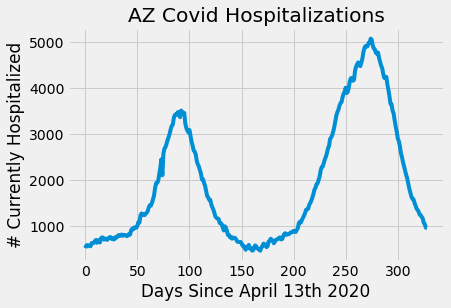

In [124]:
fig, ax = plt.subplots()
ax.plot(az_data.index.to_numpy()[::-1], az_data['hospitalizedCurrently'].to_numpy())
ax.set_xlabel('Days Since April 13th 2020')
ax.set_ylabel('# Currently Hospitalized')
ax.set_title('AZ Covid Hospitalizations')